# <center>ECSE 415 - Assignment 2</center>
  ### <center>Patrick Erath - 260719203 </center>

# Question3 - Object Detection

## 3.1 - Training

### 3.1.1 - Resize Images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

images = []

# TODO: check if grayscale is correct for HoG

# Read in each image, convert to Gray and resize, then append to list
for i in range(1,15):
    img_temp = cv2.imread("./car"+str(i)+".jpg")
    img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2GRAY) 
    img_temp = cv2.resize(img_temp, (128,128))
    images.append(img_temp)

### 3.1.2 - Compute HoG features

In [2]:
# Make a function which takes list of images as arguments
# and delivers list of HoG features as output. 

def hog_features(imgs_arr, cell_size=(4,4), block_size=(2,2), nbins=9):
    hog_feats_arr = []
    count = 0
    for img in imgs_arr:
        # Check window size
        if(img.shape[0]%16!=0 or img.shape[1]%16!=0):
            raise Exception('Invalid Image Size')
        else:
            # Compute window size
            win_XY = img.shape[0] // cell_size[0] * cell_size[1]
            
            # Compute blocks
            block_XY = block_size[0] * cell_size[0]
            
            # Create HoG object
            hog = cv2.HOGDescriptor(_winSize = (win_XY, win_XY),
                                    _blockSize = (block_XY, block_XY),
                                    _blockStride = (cell_size[1], cell_size[0]),
                                    _cellSize = (cell_size[1], cell_size[0]),
                                    _nbins = nbins
                                   )
            
            # Compute number of cells 
            n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
            
            # Compute HoG features
            hog_feats = hog.compute(img) \
                            .reshape(n_cells[1] - block_size[1] + 1,
                                     n_cells[0] - block_size[0] +1, 
                                     block_size[1], block_size[0], nbins) \
                            .transpose((1, 0, 3, 2, 4))
            
            hog_feats_arr.append(hog_feats)
            
    return hog_feats_arr
            
feats = hog_features(images)

print(len(feats))

14


### 3.1.3 - Calculate mean feature map across training images

In [39]:
# Map the HoGs
# Do we iterate over each HoG and take the average??

# Sum the features of the 14 trained images
feats_sum = 0
for i in range(0,14):
    feats_sum += feats[i]

feats_mean = feats_sum / 14

### 3.1.4 - Repeat steps 3.1.2 - 3.1.3 for images flipped vertically

In [40]:
imgs_flip = []

# Flip image about the vertical axis -> ie across y-axis
for img in images:
    imgs_flip.append(cv2.flip(img, 1))
    
feats_flip = hog_features(imgs_flip)

# Sum the features of the 14 trained images
feats_sum = 0
for i in range(0, 14):
    feats_sum += feats_flip[i]

feats_flip_mean = feats_sum / 14


### 3.1.5 - Display 9 orientation channels for first block

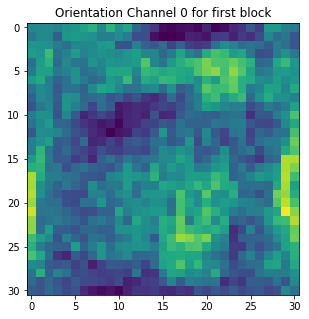

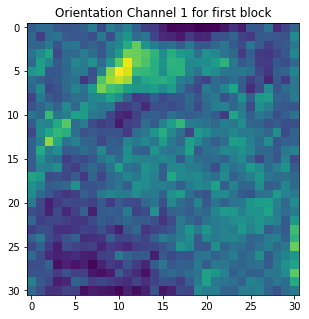

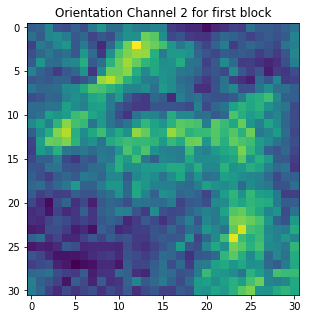

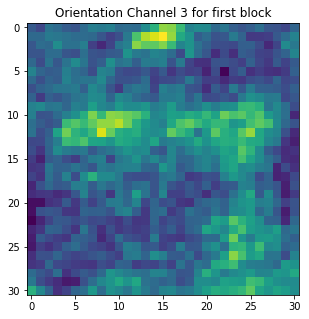

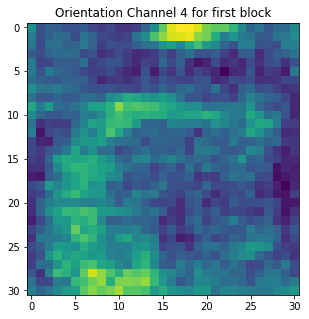

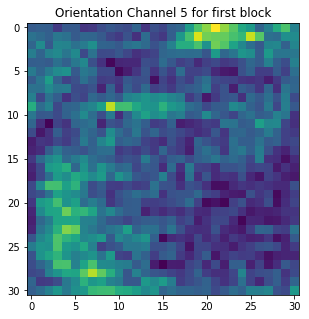

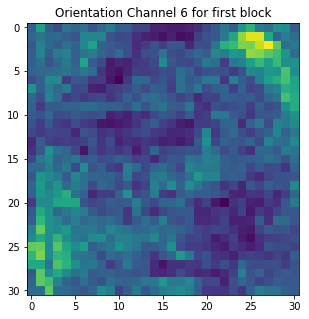

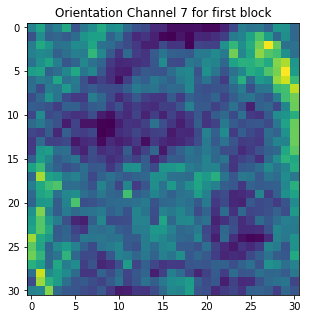

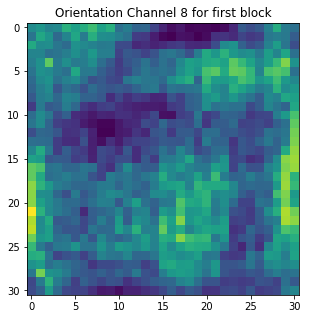

In [41]:
for i in range(0,9):
    plt.figure(figsize=(5,5))
    plt.title("Orientation Channel "+str(i)+" for first block")
    plt.imshow(feats_mean[:, :, 0,0,i])
plt.show()

## 3.2 - Testing

### 3.2.1 - Extract overlapping windows from test image

In [42]:
test_img = cv2.imread('test.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# Step size is the "step" (or over lap) when sliding 
# an overlapping 128x128 window across the image
stepSize = 32
winX = (test_img.shape[1] // stepSize) * stepSize
winY = (test_img.shape[0] // stepSize) * stepSize

test_img = cv2.resize(test_img, (winX, winY))

windows_array = []

# We iterate from x-> width limit and y-> y limit and 
# create a window of the image at each step
def sliding_window(image, stepSize, windowSize=(128,128)):
    # Sliding the window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])


# 1. Create a sliding window by sliding a 128x128 window across the image
for (x, y, window) in sliding_window(test_img, stepSize):
    if window.shape[0] != 128 or window.shape[1] != 128:
        continue
    else:
        # Append the given window to a window array
        windows_array.append(window)

### 3.2.2 - Compute HoG features for each window 

In [43]:
# NOTE: Resizing the windows to 128x128 is not necessary because 
# a sliding window of 128x128 was used. Thus the windows are already
# of size 128x128

window_feats = hog_features(windows_array)

### 3.2.3 - Compute Euclidean Distance  

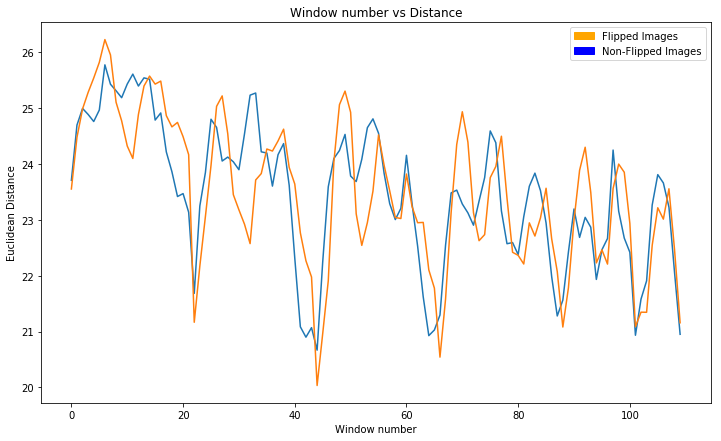

In [44]:
distances = []

# Compute distances for non-flipped images
for i in range(0, len(window_feats)):
    dist_temp = np.linalg.norm(window_feats[i]-feats_mean)
    distances.append(dist_temp)
    
distances_flipped = []

# Compute distances for non-flipped images
for i in range(0, len(window_feats)):
    dist_temp = np.linalg.norm(window_feats[i]-feats_flip_mean)
    distances_flipped.append(dist_temp)


x_axis = np.arange(0,110,1)
plt.figure(figsize=(12,7))
plt.title("Window number vs Distance")
plt.xlabel("Window number")
plt.ylabel("Euclidean Distance")

# add label
orange_patch = mpatches.Patch(color='orange', label='Flipped Images')
blue_patch = mpatches.Patch(color='blue', label='Non-Flipped Images')
plt.legend(handles=[orange_patch,blue_patch])

plt.plot(x_axis, distances)
plt.plot(x_axis, distances_flipped)

### 3.2.4 - Threshold the distances

Number of windows at threshold:  28


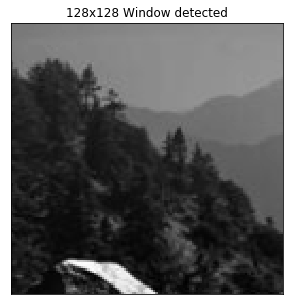

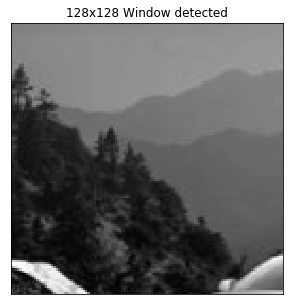

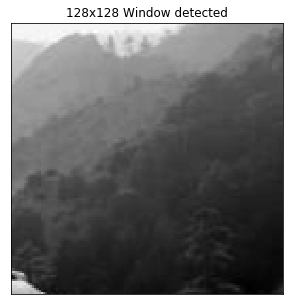

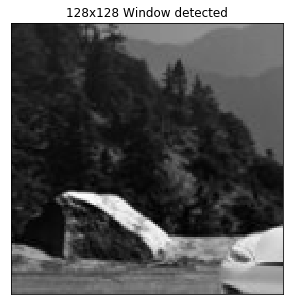

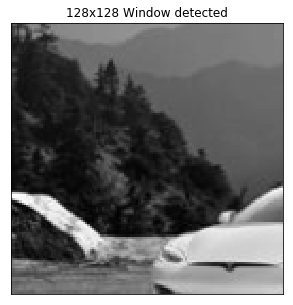

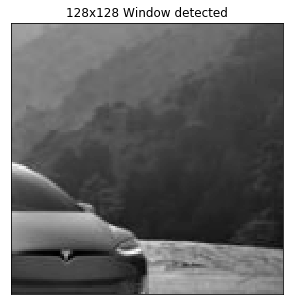

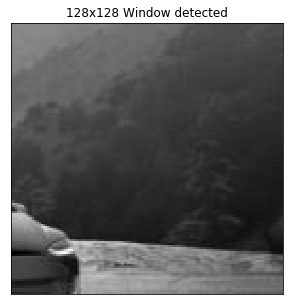

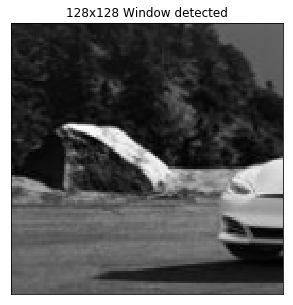

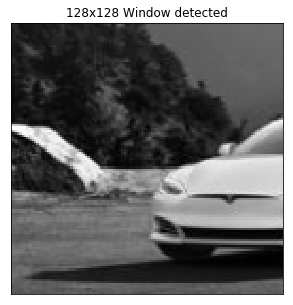

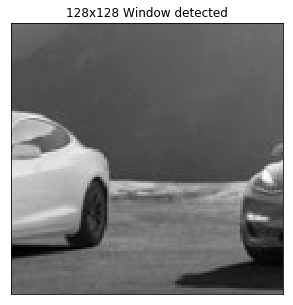

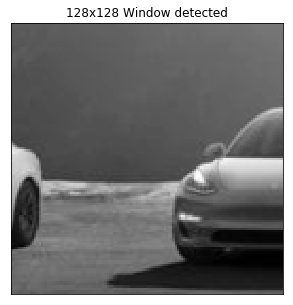

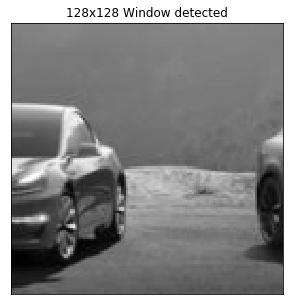

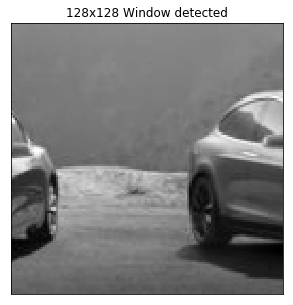

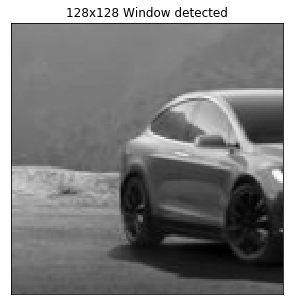

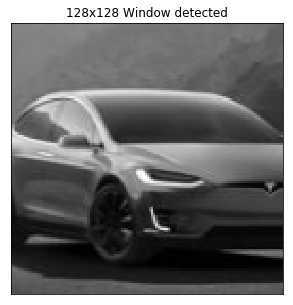

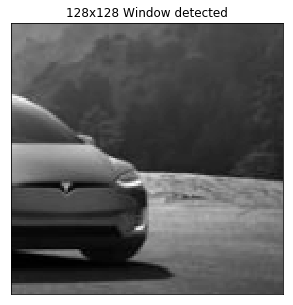

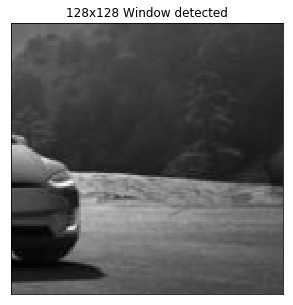

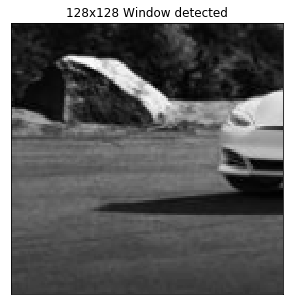

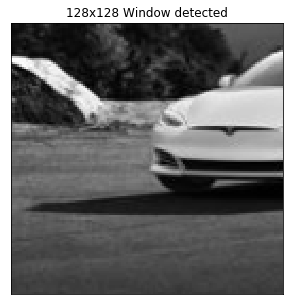

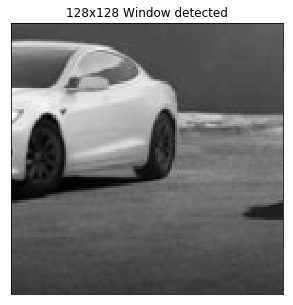

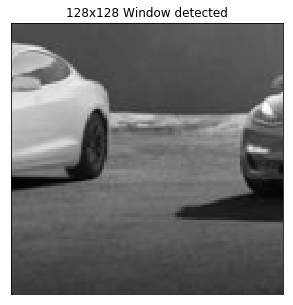

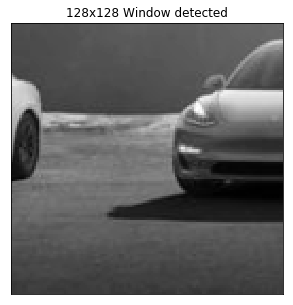

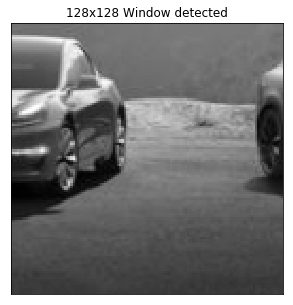

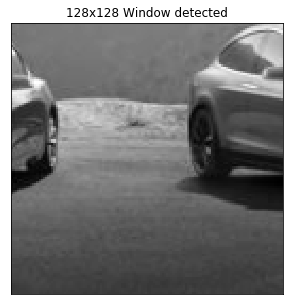

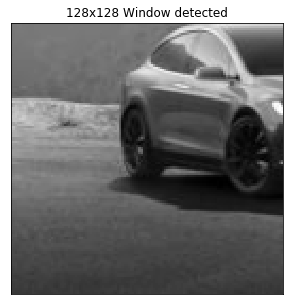

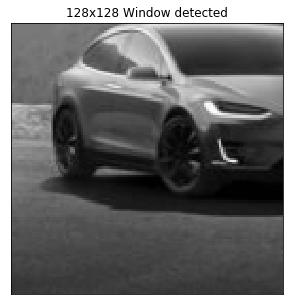

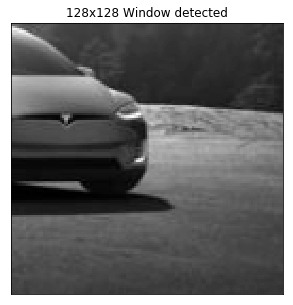

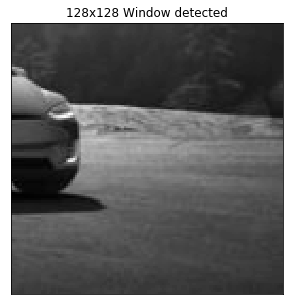

In [45]:
# Calculate the Sum of Square Distances between Flipped & Non-flipped
difference = []
for i in range(len(distances)):
    difference.append(pow(distances[i]-distances_flipped[i],2))

threshold_upper = 22.75
threshold_diff = 1.75
thresholded_windows = []

# Check upper-bounds -> Get rid of window with very high distance
# Check difference-bound -> Get rid of the windows with a high distance difference
for i in range(len(distances)):
    if(difference[i] < threshold_diff and distances_flipped[i] < threshold_upper):
        thresholded_windows.append(windows_array[i])

print("Number of windows at threshold: ",len(thresholded_windows))

for thres_wind in thresholded_windows:
    plt.rcParams.update({'figure.max_open_warning': 0})
    plt.figure(figsize=(5,5))
    plt.imshow(thres_wind, cmap='gray')
    plt.title("128x128 Window detected")
    plt.xticks([]), plt.yticks([])
plt.show()

### 3.2.5 - Experiment with the size of the window, stride and detection threshold

Number of windows at hyper thresholds:  4


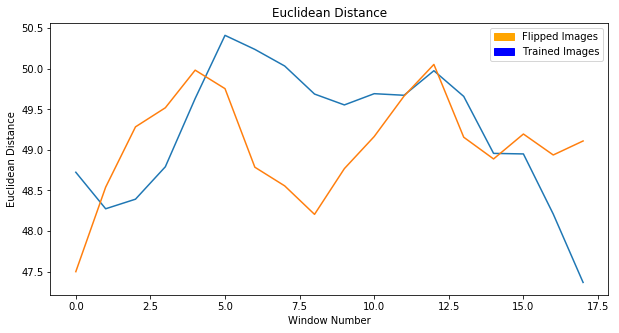

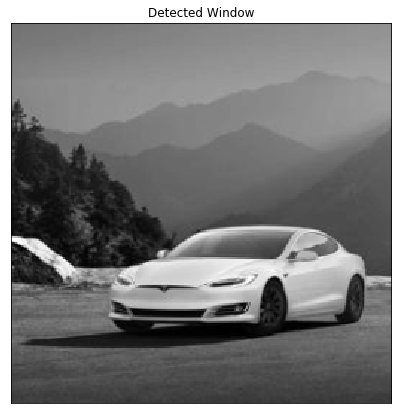

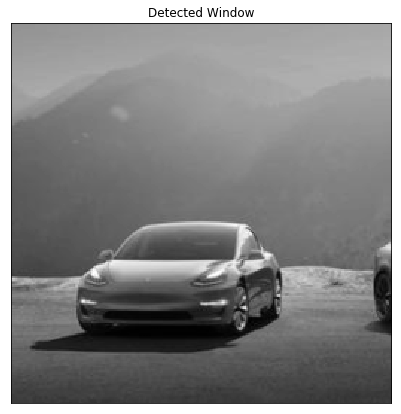

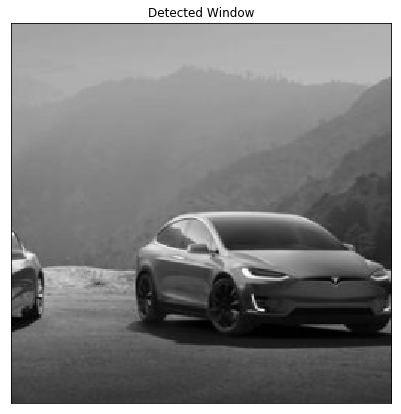

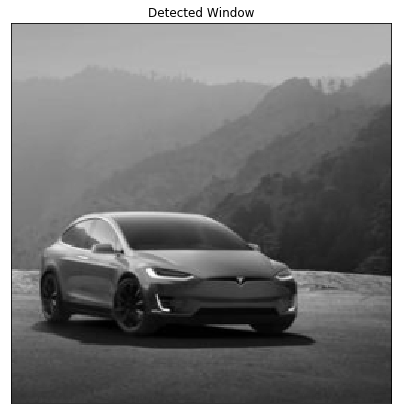

In [50]:
# * Resize images to 256x256
#load images
images = []

# HYPER PARAMETERS:
width = 256
height = 256
stepSize = 32
windowSize =(width, height)
threshold = 0.7
threshold2 = 49

# Read in the original images from scratch again
for i in range(1,15):
    img_temp = cv2.imread("./car"+str(i)+".jpg")
    img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB) 
    img_temp = cv2.resize(img_temp, (width,height))
    images.append(img_temp)

# Get the HOG_features of the images with the hyper param size
hog_feats = hog_features(images)

# Calculate the mean feature map for the new hyper param size
hog_sum=0
for i in range(0,14):
    hog_sum += hog_feats[i]
mean_feature_map = hog_sum/14

# Repeat for flipped images
flip_imgs = []
for img in images:
    img_flip = cv2.flip(img,1)
    flip_imgs.append(img_flip)

hog_feats_flipped = hog_features(flip_imgs)

# Calculate mean feature map of flipped images
hog_sum=0
for i in range(0,14):
    hog_sum += hog_feats_flipped[i]
mean_feature_map_flip = hog_sum/14

# Read in the test image
test_img = cv2.imread('test.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# Define window size and resize test image if needed
winX = (test_img.shape[1] // stepSize) * stepSize
winY = (test_img.shape[0] // stepSize) * stepSize
test_img = cv2.resize(test_img, (winX, winY))

windows_array = []
# Get over lapping windows from test image
for (x, y, window) in sliding_window(test_img, stepSize,windowSize):
    if window.shape[0] != 256 or window.shape[1] != 256:
        continue
    else:
        # Append the given window to a window array
        windows_array.append(window)

# Calculate the hog features of the windows
hog_feats_2 = hog_features(windows_array)

# Find the distance between the windows & mean for flipped and non-flipped
euclidean_distance_window = []
for i in range(0,len(hog_feats_2)):
    euclidean_distance_window.append(np.linalg.norm(hog_feats_2[i]-mean_feature_map))

euclidean_distance_flipped = []
for i in range(0,len(hog_feats_2)):
    euclidean_distance_flipped.append(np.linalg.norm(hog_feats_2[i]- mean_feature_map_flip))

# Plot the distance for flipped and non-flipped
plt.figure(figsize=(10,5))
x_axis = np.arange(0,18,1)
plt.xlabel("Window Number")
plt.ylabel("Euclidean Distance")
plt.title("Euclidean Distance")
orange_patch = mpatches.Patch(color='orange', label='Flipped Images')
blue_patch = mpatches.Patch(color='blue', label='Trained Images')
plt.legend(handles=[orange_patch,blue_patch])
plt.plot(x_axis, euclidean_distance_window )
plt.plot(x_axis, euclidean_distance_flipped )

thresholded_windows = []
# Threshold the windows by using an upper bound (to get rid of large outliers) and a
# lower bound to get rid of windows with low detection rate
for i in range(len(euclidean_distance_window)):
    if pow((euclidean_distance_window[i] - euclidean_distance_flipped[i]),2) < threshold  and euclidean_distance_flipped[i]<threshold2 :
        thresholded_windows.append(windows_array[i])

print("Number of windows at hyper thresholds: ",len(thresholded_windows))

# Display images that were found with hyper parameters
for thres_wind in thresholded_windows:
    plt.figure(figsize=(7,7))
    plt.imshow(thres_wind, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title("Detected Window")
plt.show()